In [1]:
# 必要ライブラリの導入
!pip install japanize-matplotlib | tail -n 1

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 日本語化対応
import japanize_matplotlib #日本語化matplotlib
import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定


# Bank Marketing AutoAI Model Test

以下のガイドに従って、**Watson Machine Laring認証情報**と、**Scoring URL**を調べて、結果を該当セルにコピーしてください。

### Watson Machine Learning認証情報の設定

##### 認証情報の調べ方  

(1) Watson Studioの**Settings**タブの**Associated services**の欄を見て、Machine Learningサービスの名称を調べます。  
![](https://github.com/makaishi2/sample-data/raw/master/images/waston-ml-01.png)
画面例の場合は、`pm-20-ht`。

(2) IBM Cloud管理画面 https://cloud.ibm.com/resources で、サービス名で検索をして、Machine Learningサービスを表示させます。
 ![](https://github.com/makaishi2/sample-data/raw/master/images/watson-ml-02.png)
    
(3) サービスのリンクをクリックします。

(4) **サービス資格情報** -> **資格情報の表示** をクリックして、資格情報をクリップボードにコピーします。
 ![](https://github.com/makaishi2/sample-data/raw/master/images/watson-ml-03.png)
    
(5) コピーした結果を下のセルに張り付けます。  
(必要なのは`instance_id`,`apikey`,`url`のみですが、他の項目が残っていても構いません。)

In [2]:
wml_credentials = {
  "apikey": "xxxx",
  "iam_apikey_description": "xxxx",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "xxxx",
  "instance_id": "xxxx",
  "url": "https://us-south.ml.cloud.ibm.com"
} 

### APIのScoring URL設定

#### Scoring URLの調べ方

(1) Watson Studioのプロジェクト管理画面から**Deployments**タブを選択  
リストの中から**Bank Marketing Deployment**のリンクをクリック

 ![](https://github.com/makaishi2/sample-data/raw/master/images/watson-ml-04.png)

(2) Deploymentの詳細画面で**Deployment**タブをクリックし、**Scoring End-point**をコピーします。
    
 ![](https://github.com/makaishi2/sample-data/raw/master/images/watson-ml-05.png)    

In [3]:
# scoring URLの設定
scoring_url = "xxxx"

### 必要ライブラリのimport

In [4]:
import urllib3, requests, json
import urllib.request
#import numpy as np
#import pandas as pd
#from IPython.display import display
#import matplotlib.pyplot as plt

### Watson ML呼出し準備

In [ ]:
# トークン取得
apikey = wml_credentials["apikey"]

# Get an IAM token from IBM Cloud
url     = "https://iam.bluemix.net/oidc/token"
headers = { "Content-Type" : "application/x-www-form-urlencoded" }
data    = "apikey=" + apikey + "&grant_type=urn:ibm:params:oauth:grant-type:apikey"
IBM_cloud_IAM_uid = "bx"
IBM_cloud_IAM_pwd = "bx"
response  = requests.post( url, headers=headers, data=data, 
        auth=( IBM_cloud_IAM_uid, IBM_cloud_IAM_pwd ) )
iam_token = response.json()["access_token"]

print('iam_token = ', iam_token)

In [6]:
# Header の組立て
header_token = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token}
ml_instance_id = wml_credentials["instance_id"]
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token, 'ML-Instance-ID': ml_instance_id}

### テスト用CSV読み込み
学習に利用していない 40000件のデータをまとめて読み込みます。

In [7]:
# ファイルをカレントディレクトリにダウンロード
csv_url = 'https://raw.githubusercontent.com/makaishi2/sample-data/master/data/bank-test.csv'

In [8]:
# データフレームに読み込み
df_bank_test = pd.read_csv(csv_url)

In [9]:
display(df_bank_test.head())
print(df_bank_test.shape)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,45,blue-collar,single,secondary,yes,0,no,yes,cellular,16,jul,154,2,-1,0,unknown,no
1,41,management,married,tertiary,no,5,no,no,unknown,5,jun,178,1,-1,0,unknown,no
2,40,management,single,secondary,no,906,yes,no,cellular,5,may,67,4,-1,0,unknown,no
3,25,admin.,single,secondary,no,768,yes,no,unknown,13,may,203,1,-1,0,unknown,no
4,37,services,married,primary,no,0,yes,no,cellular,12,may,631,1,344,1,success,no


(40000, 17)


### 正解データ correctの抽出

In [10]:
correct = df_bank_test.y.values
print(correct[:50])

['no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'yes' 'no' 'no' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'no']


In [11]:
display(df_bank_test.y.value_counts())

no     35321
yes     4679
Name: y, dtype: int64

In [12]:
org_rate = df_bank_test.y.value_counts().yes/ len(df_bank_test)
print('%.4f' % org_rate)

0.1170


### API呼出し用入力データ配列の作成

In [13]:
df_sub = df_bank_test.copy()

# 目的変数列の削除
df_sub = df_sub.drop('y', axis=1)

# np.nan値をNoneに置き換え
df_sub = df_sub.where((pd.notnull(df_sub)), None)

In [14]:
display(df_sub.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,45,blue-collar,single,secondary,yes,0,no,yes,cellular,16,jul,154,2,-1,0,unknown
1,41,management,married,tertiary,no,5,no,no,unknown,5,jun,178,1,-1,0,unknown
2,40,management,single,secondary,no,906,yes,no,cellular,5,may,67,4,-1,0,unknown
3,25,admin.,single,secondary,no,768,yes,no,unknown,13,may,203,1,-1,0,unknown
4,37,services,married,primary,no,0,yes,no,cellular,12,may,631,1,344,1,success


In [15]:
# DataFrameから項目名Listの生成
fields = df_sub.columns.tolist()
print(fields)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [16]:
# DataFrameから入力用Listの生成
values = df_sub.values.tolist()
# テスト用
#values = df_sub.head(2).values.tolist()
print(values[:2])

[[45, 'blue-collar', 'single', 'secondary', 'yes', 0, 'no', 'yes', 'cellular', 16, 'jul', 154, 2, -1, 0, 'unknown'], [41, 'management', 'married', 'tertiary', 'no', 5, 'no', 'no', 'unknown', 5, 'jun', 178, 1, -1, 0, 'unknown']]


In [17]:
# payload変数の組立て
payload_scoring = {"input_data": [{
    "fields": fields, 
    "values": values
}]}

### APIの呼出し

In [18]:
# APIの呼出し
response_scoring = requests.post(scoring_url,  json=payload_scoring, headers=header)

### 戻り値のparese

In [19]:
# 戻り値のparse
res = json.loads(response_scoring.text)

pred = res['predictions'][0]
pred_values = pred['values']
pred_fields = pred['fields']
df_res = pd.DataFrame(pred_values, columns = pred_fields)

In [20]:
display(df_res.head())

,prediction,probability
0,no,"[0.9983722226959316, 0.0016277773040684318]"
1,no,"[0.9992783014554109, 0.0007216985445891417]"
2,no,"[0.9991979530518555, 0.0008020469481444956]"
3,no,"[0.9963876224716701, 0.0036123775283299154]"
4,yes,"[0.46651503654818227, 0.5334849634518177]"


### 精度評価

In [21]:
# 予測値の抽出
prediction = df_res['prediction'].values

# 確率値のリスト取得
w1 = df_res['probability'].values.tolist()
probas = [item[1] for item in w1]

In [22]:
# Accuracyの計算
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(correct, prediction)

In [23]:
# ROC AUCの計算
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# fpr, tpr値の取得
fpr, tpr, thresholds = roc_curve(correct, probas, pos_label='yes')

# ROC AUCの計算
roc_auc = auc(fpr, tpr)

In [24]:
# 混同行列の計算
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(correct, prediction)
df_matrix = pd.DataFrame(matrix, columns=['no', 'yes'], index=['no', 'yes'])

### 精度評価結果表示

In [25]:
### 混同行列表示
display(df_matrix)

,no,yes
no,34025,1296
yes,2536,2143


In [29]:
# precision / recall
from sklearn.metrics import classification_report
print(classification_report(correct, prediction))

              precision    recall  f1-score   support

          no       0.93      0.96      0.95     35321
         yes       0.62      0.46      0.53      4679

   micro avg       0.90      0.90      0.90     40000
   macro avg       0.78      0.71      0.74     40000
weighted avg       0.89      0.90      0.90     40000



#### 上記の意味

元々は11.7%しか成約がなかったのが、  
モデルで予測することにより**62%成約できる**ことになります。  
**成約できそうな顧客の46%はこのモデルで洗い出しができる**ことになります。

In [30]:
# AccuracyとROC AUCの表示

print("Accuracy: %0.3f" % accuracy)
print("ROC AUC : %0.3f" % roc_auc)

Accuracy: 0.904
ROC AUC : 0.920


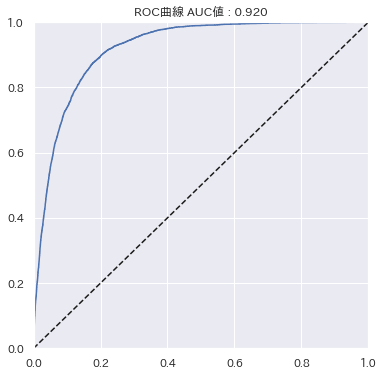

In [31]:
# ROC曲線の描画

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC曲線 AUC値 : %0.3f" % roc_auc)
plt.show()

In [32]:
# 正解データの yesとnoの数の計算
y_count = np.count_nonzero(correct == 'yes')
n_count = np.count_nonzero(correct == 'no')
print(y_count, n_count)

# 予測値がyesだったもののうち、正解データのyesとnoの数
yy_count = df_matrix.yes.yes
yn_count = df_matrix.yes.no
print(yy_count, yn_count)

4679 35321
2143 1296


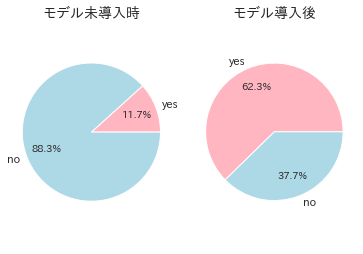

In [33]:
# モデルを使わない場合と使った場合の成約率の比較

plt.subplot(1, 2, 1)
label = ['yes', 'no']
colors = ["lightpink", "lightblue"]
x = np.array([y_count, n_count])
plt.pie(x, labels=label, colors=colors,
       autopct="%1.1f%%", pctdistance=0.7)
plt.title('モデル未導入時', fontsize=14)
plt.axis('equal')
 
plt.subplot(1, 2, 2)
label = ['yes', 'no']
colors = ["lightpink", "lightblue"]
x = np.array([yy_count, yn_count])
plt.pie(x, labels=label, colors=colors,
       autopct="%1.1f%%", pctdistance=0.7)
plt.title('モデル導入後', fontsize=14)
plt.axis('equal')

plt.show()